In [1]:
!pip install pykalman

In [1]:
%pip install yfinance pandas numpy matplotlib seaborn scikit-learn tensorflow keras hmmlearn statsmodels ta transformers torch tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install yfinance

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ta.momentum import RSIIndicator
from ta.trend import MACD, SMAIndicator, EMAIndicator
from pykalman import KalmanFilter
from hmmlearn.hmm import GaussianHMM
from sklearn.mixture import BayesianGaussianMixture
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import warnings
warnings.filterwarnings("ignore")

Note: you may need to restart the kernel to use updated packages.


c:\Users\viswa\GithubClonedRepos\PAML\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[*********************100%***********************]  1 of 1 completed


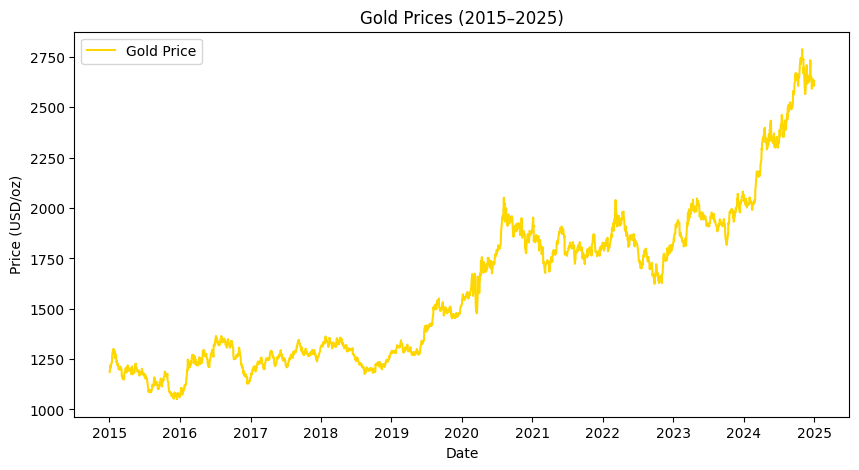

Price,GOLD
Ticker,GC=F
Date,
2015-01-02,1186.000000
2015-01-05,1203.900024
2015-01-06,1219.300049
2015-01-07,1210.599976
2015-01-08,1208.400024


In [3]:
# --- Load Gold Prices ---
df = yf.download("GC=F", start="2015-01-01", end="2025-01-01")  # COMEX Gold Futures
df = df[["Close"]].rename(columns={"Close": "GOLD"})
df.dropna(inplace=True)

plt.figure(figsize=(10,5))
plt.plot(df["GOLD"], label="Gold Price", color='gold')
plt.title("Gold Prices (2015–2025)")
plt.xlabel("Date")
plt.ylabel("Price (USD/oz)")
plt.legend()
plt.show()

df.head()

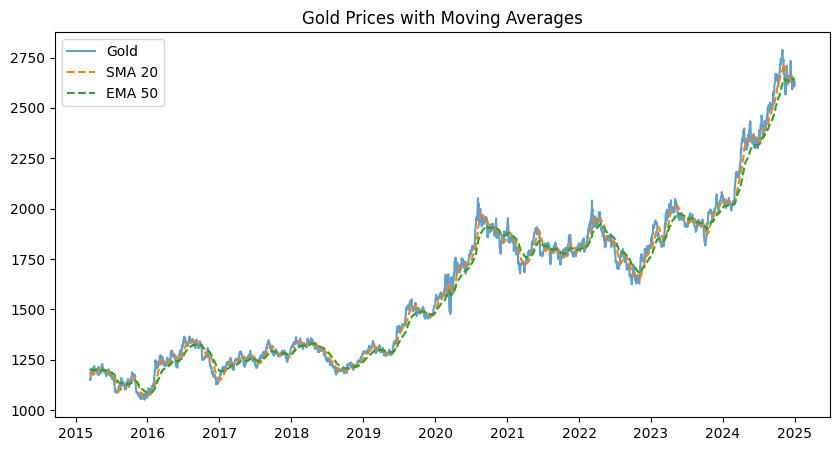

Price,GOLD,RSI,MACD,Signal_Line,SMA_20,EMA_50
Ticker,GC=F,,,,,
Date,,,,,,
2024-12-24,2620.000000,45.646373,-9.144972,-3.899556,2647.054993,2641.561512
2024-12-26,2638.800049,48.855933,-8.295974,-4.778840,2647.979993,2641.453220
2024-12-27,2617.199951,45.529411,-9.259349,-5.674941,2646.844995,2640.502111
2024-12-30,2606.100098,43.876126,-10.794069,-6.698767,2644.300000,2639.153013
2024-12-31,2629.199951,48.099898,-10.030752,-7.365164,2644.015002,2638.762696


In [4]:
# --- 4. Technical Indicators (RSI, MACD, SMA, EMA) ---

# Ensure the 'GOLD' column is a 1-D Series
gold_series = pd.Series(np.ravel(df["GOLD"].values), index=df.index)

# RSI
df["RSI"] = RSIIndicator(close=gold_series, window=14).rsi()

# MACD
macd_obj = MACD(close=gold_series)
df["MACD"] = pd.Series(np.ravel(macd_obj.macd().values), index=df.index)
df["Signal_Line"] = pd.Series(np.ravel(macd_obj.macd_signal().values), index=df.index)

# Moving Averages
df["SMA_20"] = SMAIndicator(close=gold_series, window=20).sma_indicator()
df["EMA_50"] = EMAIndicator(close=gold_series, window=50).ema_indicator()

# Clean up
df.dropna(inplace=True)

# Plot
plt.figure(figsize=(10,5))
plt.plot(df["GOLD"], label="Gold", alpha=0.7)
plt.plot(df["SMA_20"], label="SMA 20", linestyle="--")
plt.plot(df["EMA_50"], label="EMA 50", linestyle="--")
plt.title("Gold Prices with Moving Averages")
plt.legend()
plt.show()

df.tail()

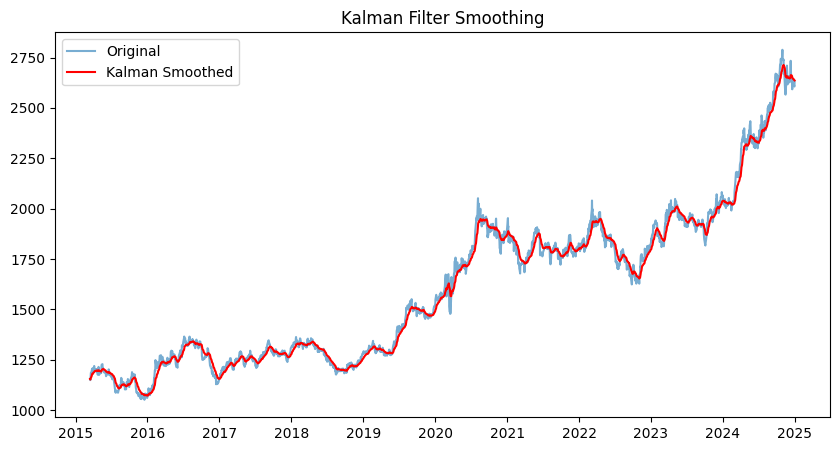

In [5]:
# --- Kalman Filter Smoothing ---
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=df["GOLD"].values[0],
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(df["GOLD"].values)
df["Kalman_Smoothed"] = state_means

plt.figure(figsize=(10,5))
plt.plot(df["GOLD"], label="Original", alpha=0.6)
plt.plot(df["Kalman_Smoothed"], label="Kalman Smoothed", color='red')
plt.legend()
plt.title("Kalman Filter Smoothing")
plt.show()

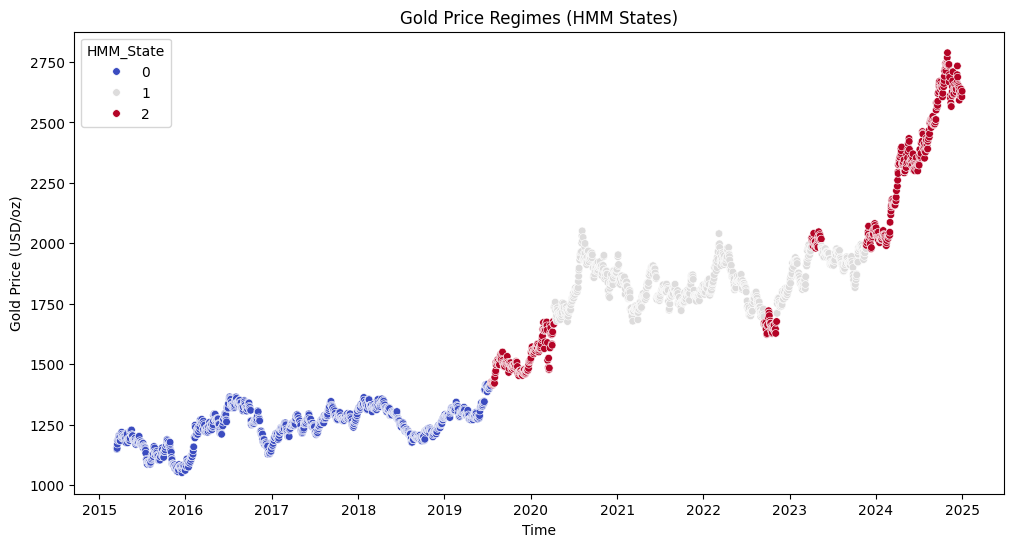

In [6]:
# --- 6. Hidden Markov Model (HMM) ---

# Ensure the gold data is 1-D for fitting and plotting
gold_vals = np.ravel(df["GOLD"].values)

# Fit the model
hmm = GaussianHMM(n_components=3, covariance_type="diag", n_iter=200)
hmm.fit(gold_vals.reshape(-1, 1))
hidden_states = hmm.predict(gold_vals.reshape(-1, 1))

# Store in DataFrame
df["HMM_State"] = hidden_states

# Plot — make sure everything passed to seaborn is 1-D
plt.figure(figsize=(12,6))
sns.scatterplot(
    x=df.index,
    y=np.ravel(df["GOLD"].values),
    hue=df["HMM_State"],
    palette="coolwarm",
    s=30
)
plt.title("Gold Price Regimes (HMM States)")
plt.xlabel("Time")
plt.ylabel("Gold Price (USD/oz)")
plt.show()

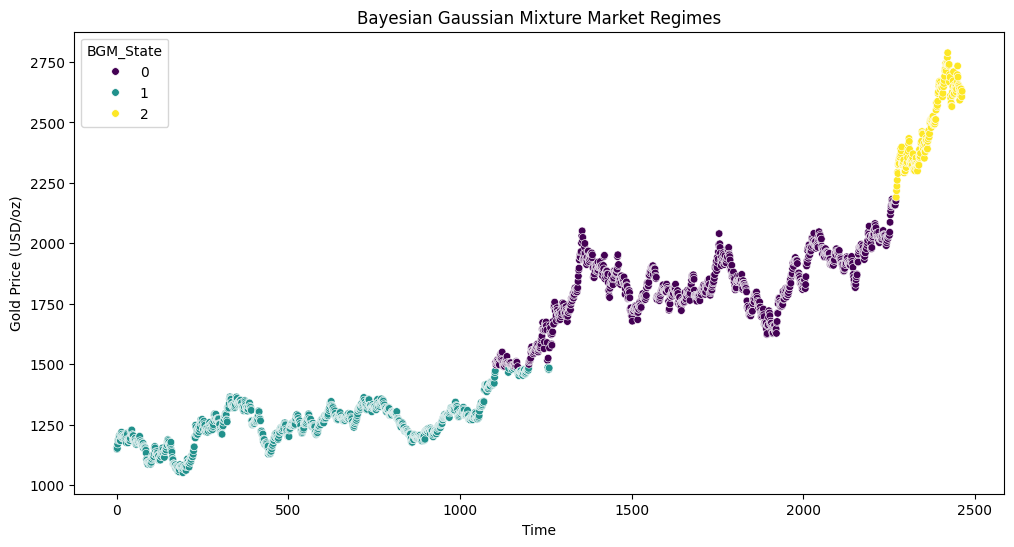

In [7]:
# --- 7. Bayesian Gaussian Mixture (BGM) ---

# Make sure gold prices are strictly 1-D
gold_vals = np.ravel(df["GOLD"].values)

# Fit Bayesian Gaussian Mixture model
bgm = BayesianGaussianMixture(n_components=3, covariance_type="diag", n_init=5)
bgm.fit(gold_vals.reshape(-1, 1))
bgm_states = bgm.predict(gold_vals.reshape(-1, 1))

# Store the states in DataFrame
df["BGM_State"] = bgm_states

# Plot regimes — ensure all arrays are 1-D
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.arange(len(gold_vals)),
    y=gold_vals,
    hue=df["BGM_State"].astype(int),
    palette="viridis",
    s=30
)
plt.title("Bayesian Gaussian Mixture Market Regimes")
plt.xlabel("Time")
plt.ylabel("Gold Price (USD/oz)")
plt.show()

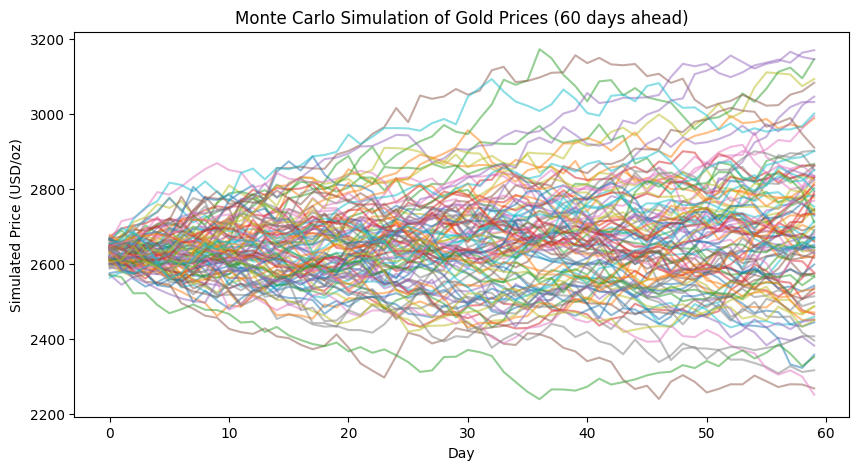

In [8]:
# --- 8. Monte Carlo Simulation for Gold Prices ---

import numpy as np
import matplotlib.pyplot as plt

# Extract and clean gold prices
gold_prices = df["GOLD"].values.flatten()

# Calculate daily log returns
log_returns = np.diff(np.log(gold_prices))
mu = np.mean(log_returns)
sigma = np.std(log_returns)

# Simulation parameters
n_simulations = 100     # number of simulated paths
n_days = 60             # days to simulate

# Initialize matrix for simulations
simulations = np.zeros((n_days, n_simulations))

# Run simulations
for sim in range(n_simulations):
    price_series = [gold_prices[-1]]  # start from last known price
    for day in range(1, n_days + 1):
        # geometric Brownian motion formula
        price = price_series[-1] * np.exp((mu - 0.5 * sigma**2) + sigma * np.random.normal())
        price_series.append(price)
    # Ensure conversion to numpy array for assignment
    simulations[:, sim] = np.array(price_series[1:])

# Plot all simulated paths
plt.figure(figsize=(10, 5))
plt.plot(simulations, alpha=0.5)
plt.title("Monte Carlo Simulation of Gold Prices (60 days ahead)")
plt.xlabel("Day")
plt.ylabel("Simulated Price (USD/oz)")
plt.show()

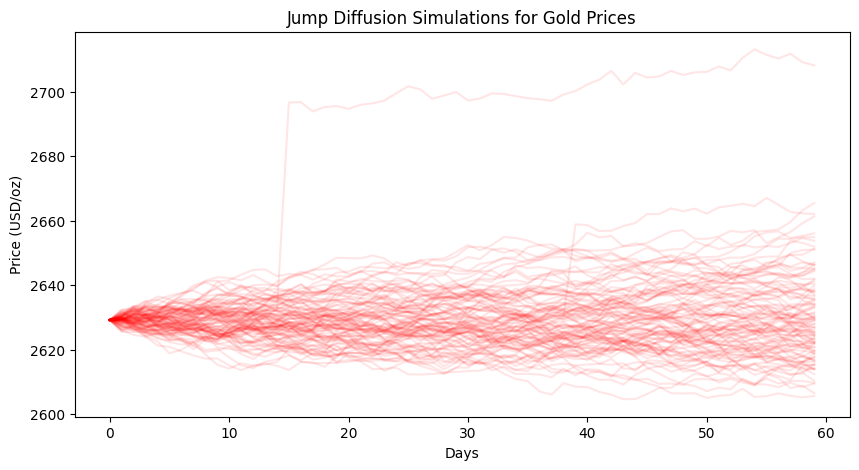

In [9]:
# --- Jump Diffusion Model ---

def jump_diffusion_sim(S0, mu, sigma, lamb, mu_j, sigma_j, T=1, steps=252, n_sims=100):
    dt = T / steps
    prices = np.zeros((steps, n_sims))
    for sim in range(n_sims):
        prices[0, sim] = S0
        for t in range(1, steps):
            N = np.random.poisson(lamb * dt)
            # If no jumps, J should be 0.0
            J = np.sum(np.random.normal(mu_j, sigma_j, N)) if N > 0 else 0.0
            drift = (mu - 0.5 * sigma**2) * dt
            diffusion = sigma * np.sqrt(dt) * np.random.normal()
            prices[t, sim] = prices[t-1, sim] * np.exp(drift + diffusion + J)
    return prices

# compute parameters (ensure scalars)
mu = float(df["GOLD"].pct_change().mean())
sigma = float(df["GOLD"].pct_change().std())
S0 = float(df["GOLD"].iloc[-1])

# simulate using the notebook's n_days and n_simulations (already defined in earlier cells)
# use T = n_days / 252 so steps correspond to n_days
jd_prices = jump_diffusion_sim(S0, mu, sigma, lamb=0.1, mu_j=-0.02, sigma_j=0.05, T=n_days/252, steps=n_days, n_sims=n_simulations)

plt.figure(figsize=(10,5))
plt.plot(jd_prices, alpha=0.1, color='red')
plt.title("Jump Diffusion Simulations for Gold Prices")
plt.xlabel("Days")
plt.ylabel("Price (USD/oz)")
plt.show()

In [10]:
# --- NLTK Sentiment Analysis ---
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

headlines = [
    "Gold prices surge amid economic uncertainty",
    "Concerns rise over declining gold demand",
    "Global investors flee to gold as safe haven",
]

def get_nltk_sentiment(texts):
    sentiments = []
    for text in texts:
        scores = sia.polarity_scores(text)
        compound = scores['compound']
        
        # Classify based on compound score
        if compound >= 0.05:
            sentiment = "Positive"
        elif compound <= -0.05:
            sentiment = "Negative"
        else:
            sentiment = "Neutral"
        sentiments.append(sentiment)
    return sentiments

sentiments = get_nltk_sentiment(headlines)
for h, s in zip(headlines, sentiments):
    print(f"{h} → {s}")

Gold prices surge amid economic uncertainty → Negative
Concerns rise over declining gold demand → Negative
Global investors flee to gold as safe haven → Positive


Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0012 - val_loss: 4.8210e-04
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 9.5236e-04 - val_loss: 3.5901e-04
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 8.4832e-04 - val_loss: 0.0035
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 7.9051e-04 - val_loss: 3.2617e-04
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 6.6749e-04 - val_loss: 3.2735e-04
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 6.9290e-04 - val_loss: 3.6931e-04
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 6.3468e-04 - val_loss: 4.7025e-04
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 5.1744e-04 - val_loss: 6.1925e-04
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 5.8101e-04 - val_loss: 6.2325e-04
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 4.6063e-04 - val_loss: 3.

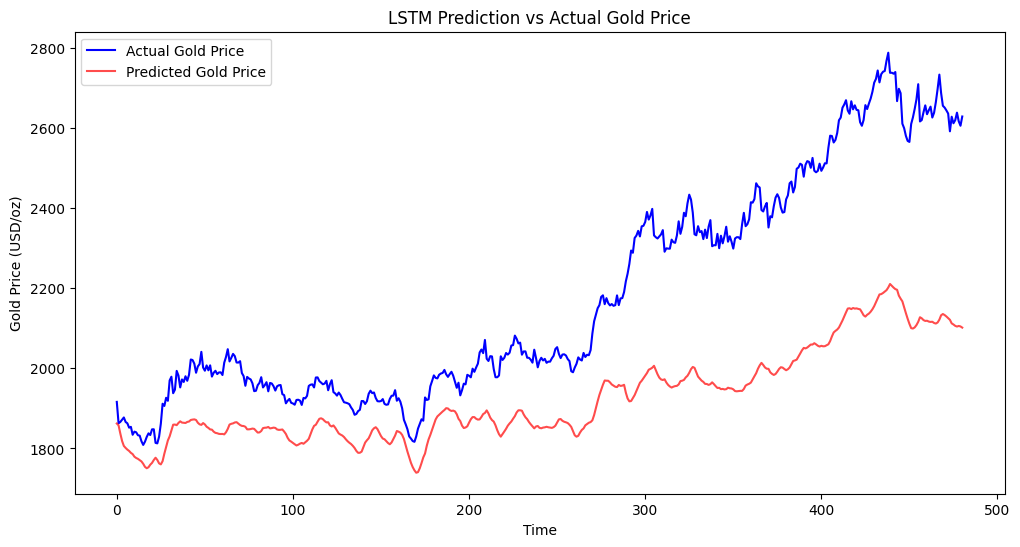

RMSE: 303.0053


In [11]:
# --- 9. LSTM Training and Gold Price Prediction ---

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

# --- Prepare Data ---

# Select numerical columns (excluding date if any)
features = df.select_dtypes(include=[np.number]).copy()

# Choose your target column here
target_col = "GOLD"  # <-- change to "SILVER" later if needed

if target_col not in features.columns:
    raise ValueError(f"{target_col} column not found in dataframe. Available columns: {list(features.columns)}")

# Fill NaN values
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

# Create sequences for LSTM
def create_sequences(data, seq_len=60):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i, features.columns.get_loc(target_col)])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_data, seq_len)

# Split into train/test (80/20)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Build LSTM Model ---

model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

# --- Make Predictions ---
y_pred = model.predict(X_test)

# Inverse transform predictions & actuals to original scale
scaler_for_target = MinMaxScaler()
scaler_for_target.fit(features[[target_col]])
y_test_rescaled = scaler_for_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_rescaled = scaler_for_target.inverse_transform(y_pred)

# --- Plot Predicted vs Actual ---
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Gold Price', color='blue')
plt.plot(y_pred_rescaled, label='Predicted Gold Price', color='red', alpha=0.7)
plt.title("LSTM Prediction vs Actual Gold Price")
plt.xlabel("Time")
plt.ylabel("Gold Price (USD/oz)")
plt.legend()
plt.show()

# --- RMSE ---
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
print(f"RMSE: {rmse:.4f}")
from sklearn.metrics import r2_score

# Calculate R²
#r2 = r2_score(y_test, predicted_prices)
#print(f"R² Score: {r2:.4f}")

In [12]:
# --- Model Evaluation Metrics ---

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

# Try to detect prediction variable
try:
    y_pred_eval = predicted_prices
except NameError:
    try:
        y_pred_eval = predictions
    except NameError:
        try:
            y_pred_eval = y_pred
        except NameError:
            raise NameError("Couldn't find prediction variable. Make sure your LSTM cell outputs predictions.")

# Ensure both y_test and predictions are 1D arrays
y_test = np.array(y_test).flatten()
y_pred_eval = np.array(y_pred_eval).flatten()

# Calculate metrics
r2 = r2_score(y_test, y_pred_eval)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_eval))
mae = mean_absolute_error(y_test, y_pred_eval)

# Print results
print("📊 Model Performance Metrics:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

📊 Model Performance Metrics:
R² Score: -0.1934
RMSE: 0.1744
MAE: 0.1455


In [ ]:
# --- Save Future Predictions to CSV ---

import pandas as pd
from datetime import datetime, timedelta

# Get the last date from the original data
last_date = df.index[-1]

# Generate future dates for predictions (same number as test predictions)
future_dates = [last_date + timedelta(days=i) for i in range(1, len(y_pred_rescaled) + 1)]

# Create a DataFrame with future predictions
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': y_pred_rescaled.flatten()
})

# Save to CSV
output_filename = f'gold_future_predictions_{datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
future_predictions_df.to_csv(output_filename, index=False)
print(f"✅ Future predictions saved to: {output_filename}")
print(f"📊 Total predictions: {len(future_predictions_df)}")
print(f"📈 Price range: ${future_predictions_df['Predicted_Price'].min():.2f} - ${future_predictions_df['Predicted_Price'].max():.2f}")
print("\nFirst 5 predictions:")
print(future_predictions_df.head())
